# NPP Choice

In [ ]:
# imports
import xarray as xr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np 

In [2]:
# Create the mapping MM-DD -> day (except leap years)
days = pd.date_range('2001-01-01', '2001-12-31')  # 2001 not a leap year
mmdd_to_day = {d.strftime('%m-%d'): i+1 for i, d in enumerate(days)}

## VGPM

In [3]:
path_vgpm='/data/rd_exchange/sroyer/SEAPOPYM/daily_pp_papa_1998_2020.nc'
ds_vgpm = xr.open_dataset(path_vgpm,engine='netcdf4')

In [4]:
ds_vgpm

<xarray.Dataset> Size: 302kB
Dimensions:  (time: 8395)
Coordinates:
  * time     (time) datetime64[ns] 67kB 1998-01-01T12:00:00 ... 2020-12-31T12...
    day      (time) <U5 168kB ...
Data variables:
    npp      (time) float64 67kB ...

In [5]:
# Temporal Median
# Extract npp 
npp_vgpm = ds_vgpm['npp']

# assign day coordinate in ds_npp_vgpm
# Extract MM-DD 
mmdd = pd.to_datetime(npp_vgpm.time.values).strftime('%m-%d')
# transform MM-DD in indice of day in year (1->365)
day_noleap = pd.Series(mmdd).map(mmdd_to_day).values
# add coord day
npp_vgpm = npp_vgpm.assign_coords(day=("time", day_noleap))

# Compute median
median_npp_vgpm = npp_vgpm.groupby('day').median('time')

#smooth median 
# Pad 15 days on each side cyclically
pad_width = 15
extended = xr.concat(
    [median_npp_vgpm.isel(day=slice(-pad_width, None)),  # wrap end -> beginning
     median_npp_vgpm,
     median_npp_vgpm.isel(day=slice(0, pad_width))],     # wrap beginning -> end
    dim='day'
)

# Fix the 'day' coordinate (for clarity)
extended['day'] = np.arange(-pad_width, 365 + pad_width)

# Apply the rolling mean
smoothed = extended.rolling(day=30, center=True).mean()

# Extract the center part (original days)
median_npp_vgpm_smooth = smoothed.sel(day=slice(1, 365))

In [6]:
# plot 
# Group by year
years = pd.DatetimeIndex(ds_vgpm.time.values).year.unique()

fig = go.Figure()

# Plot one line per year 
for year in years:
    yearly_data = ds_vgpm.sel(time=str(year))["npp"]
    fig.add_trace(go.Scatter(
        x=yearly_data.time.dt.dayofyear,
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black
fig.add_trace(go.Scatter(
    x=median_npp_vgpm['day'],
    y=median_npp_vgpm.values,
    mode='lines',
    name='Median',
    line=dict(color='black', width=2)
))

fig.update_layout(
    title='Daily VGPM Primary Productivity Time Series (1998-2020) at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]',
    template='plotly_white'
)

fig.show()



In [102]:
from scipy.optimize import curve_fit

x_date = median_npp_vgpm['day'].values
y_npp = median_npp_vgpm.values

# Remove NaNs
mask = ~np.isnan(y_npp)
x_clean = x_date[mask]
y_clean = y_npp[mask]

# Fourier series function (order 4)
def fourier_series(x, *params):
    result = params[0]  # a0
    N = (len(params) - 1) // 2
    for n in range(1, N + 1):
        a = params[2 * n - 1]
        b = params[2 * n]
        result += a * np.cos(2 * np.pi * n * x / 365) + b * np.sin(2 * np.pi * n * x / 365)
    return result

order = 4
initial_guess = [np.mean(y_clean)] + [0] * (order * 2) # ao mean of clim, a1, b1, .. an, bn -> 0

# Fit
params, _ = curve_fit(fourier_series, x_clean, y_clean, p0=initial_guess)

# Generate daily values
days = np.arange(365)
vgpm_daily = fourier_series(days, *params)

In [105]:
# plot 
# Group by year
years = pd.DatetimeIndex(ds_vgpm.time.values).year.unique()

fig = go.Figure()

# Plot one line per year 
for year in years:
    yearly_data = ds_vgpm.sel(time=str(year))["npp"]
    fig.add_trace(go.Scatter(
        x=yearly_data.time.dt.dayofyear,
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot median in black
fig.add_trace(go.Scatter(
    x=median_npp_vgpm['day'],
    y=median_npp_vgpm.values,
    mode='lines',
    name='Median',
    line=dict(color='grey', width=2)
))
# Add the interpolated Fourier daily curve
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=vgpm_daily,
    mode='lines',
    name='Fourier Interpolated Median',
    line=dict(color='black', width=3, dash='dash')
))

fig.update_layout(
    title='Daily VGPM Primary Productivity Time Series (1998-2020) at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]',
    template='plotly_white'
)

fig.show()



## HYCOM 0.030 kg m-3

Explanation model calculations (VGPM, CbPM, CAFE) http://orca.science.oregonstate.edu/vgpm.model.php

### WESTBERRY - CbPM


In [7]:
path_west='/data/rd_exchange/sroyer/SEAPOPYM/NPP/1998_2022_NPP_WESTBERRY_CBPM_25KM_8D.nc'
ds_west = xr.open_dataset(path_west,engine='netcdf4')

In [8]:
ds_west

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 1150, lat: 720, lon: 1440)
Coordinates:
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time     (time) datetime64[ns] 9kB 1998-01-01 1998-01-09 ... 2022-12-27
Data variables:
    CbPM     (time, lat, lon) float64 10GB ...

In [9]:
# Select Area of Papa station + time 1998-2020 to be consistent with other forcings
ds_west_papa = ds_west.sel(
    lat=slice(48.5, 50.5),  
    lon=slice(-130.5, -128.5),
    time=slice("1998", "2020"),
)
# Spatial mean
ds_west_papa=ds_west_papa.mean(dim=['lon','lat'],skipna=True)

<div class="alert alert-danger">
    <strong>Warning :</strong> Data every 8 days; For leap years, from march one day difference 
</div>

In [10]:
# Temporal Median
n_periods = 46  # 8-day resolution over 365 days

# create 8 days period index
period_index = np.tile(np.arange(n_periods), int(len(ds_west_papa.time) / n_periods) + 1)[:len(ds_west_papa.time)]
ds_west_papa = ds_west_papa.assign_coords(period_8d=("time", period_index))

# Compute 8_day climatology
clim_8d_west = ds_west_papa.groupby("period_8d").median("time", skipna=True)

# Rename each group 0 45 (group of 8 days) into day in the year (1-365)
day_of_year = [1 + i * 8 for i in range(46)]

# check dims
clim_8d_west = clim_8d_west.assign_coords(day_of_year=("period_8d", day_of_year))

# Rename dims
clim_8d_west = clim_8d_west.swap_dims({"period_8d": "day_of_year"}).drop_vars("period_8d")

In [11]:
# plot 
# Group by year
years = pd.DatetimeIndex(ds_west_papa.time.values).year.unique()

fig = go.Figure()

# Plot one line per year 
for year in years:
    yearly_data = ds_west_papa.sel(time=str(year))["CbPM"]
    fig.add_trace(go.Scatter(
        x=yearly_data.time.dt.dayofyear,
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black
fig.add_trace(go.Scatter(
    x=clim_8d_west['day_of_year'],
    y=clim_8d_west['CbPM'].values,
    mode='lines',
    name='Median',
    line=dict(color='black', width=2)
))

fig.update_layout(
    title='8-day CbPM WESTBERRY Primary Productivity Time Series (1998-2020) at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]',
    template='plotly_white'
)

fig.show()



To have daily npp like the others forcings and to smooth the curve, lets fit the median with a Fourier serie function.

In [114]:
from scipy.optimize import curve_fit

x_date = clim_8d_west['day_of_year'].values
y_npp = clim_8d_west['CbPM'].values

# Remove NaNs
mask = ~np.isnan(y_npp)
x_clean = x_date[mask]
y_clean = y_npp[mask]

# Fourier series function (order 4)
def fourier_series(x, *params):
    result = params[0]  # a0
    N = (len(params) - 1) // 2
    for n in range(1, N + 1):
        a = params[2 * n - 1]
        b = params[2 * n]
        result += a * np.cos(2 * np.pi * n * x / 365) + b * np.sin(2 * np.pi * n * x / 365)
    return result

order = 4
initial_guess = [np.mean(y_clean)] + [0] * (order * 2) # ao mean of clim, a1, b1, .. an, bn -> 0

# Fit
params, _ = curve_fit(fourier_series, x_clean, y_clean, p0=initial_guess)

# Generate daily values
days = np.arange(365)
west_daily = fourier_series(days, *params)

<div style="padding: 10px; border-radius: 5px; background-color: #cce5ff; color: #004085; border-left: 5px solid #007bff;">
    <strong>Note :</strong> To fit the double peak, a Fourier Serie of order 4 was used.
</div>

In [115]:
# Plot with interpolated daily values

# Group by year
years = pd.DatetimeIndex(ds_west_papa.time.values).year.unique()

fig = go.Figure()

# Plot one line per year 
for year in years:
    yearly_data = ds_west_papa.sel(time=str(year))["CbPM"]
    fig.add_trace(go.Scatter(
        x=yearly_data.time.dt.dayofyear,
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black
fig.add_trace(go.Scatter(
    x=clim_8d_west['day_of_year'],
    y=clim_8d_west['CbPM'].values,
    mode='lines',
    name='Median',
    line=dict(color='grey', width=3)
))

# Add the interpolated Fourier daily curve
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=west_daily,
    mode='lines',
    name='Fourier Interpolated Median',
    line=dict(color='black', width=3, dash='dash')
))
fig.update_layout(
    title='Daily interpolated CbPM WESTBERRY Primary Productivity Time Series (1998-2020) at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]', 
    template='plotly_white'
)

fig.show()


In [116]:
# # Export interpolated daily values of CbPM WESTBERRY npp
# # Create a coordinate for the day of year (1 to 365)
# days = np.arange(1, 366)  # day 1 to 365

# # Create xarray DataArray
# west_daily_da = xr.DataArray(
#     data=west_daily,
#     coords={'days': days},
#     dims=['days'],
#     name='npp'
# )

# west_daily_da.attrs['long_name'] = 'Interpolated daily npp'
# west_daily_da.attrs['units'] = 'mg C m-2 day-1'
# # Export to NetCDF
# west_daily_da.to_netcdf('/data/rd_exchange/sroyer/SEAPOPYM/NPP/daily_WESTBERRY_papa_1998_2020.nc')

### BEHRENFELD -CbPM

In [12]:
path_behr='/data/rd_exchange/sroyer/SEAPOPYM/NPP/1998_2022_NPP_BEHRENFELD_CBPM_25KM_8D.nc'
ds_behr = xr.open_dataset(path_behr,engine='netcdf4')

In [13]:
ds_behr

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 1150, lat: 720, lon: 1440)
Coordinates:
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time     (time) datetime64[ns] 9kB 1998-01-01 1998-01-09 ... 2022-12-27
Data variables:
    CbPM     (time, lat, lon) float64 10GB ...

In [14]:
# Select Area of Papa station + time 1998-2020 to be consistent with other forcings
ds_behr_papa = ds_behr.sel(
    lat=slice(48.5, 50.5),  
    lon=slice(-130.5, -128.5),
    time=slice("1998", "2020"),
)
# Spatial mean
ds_behr_papa=ds_behr_papa.mean(dim=['lon','lat'],skipna=True)

<div class="alert alert-danger">
    <strong>Warning :</strong> Data every 8 days; For leap years, from march one day difference 
</div>

In [15]:
# Temporal Median
n_periods = 46  # 8-day resolution over 365 days

# create 8 days period index
period_index = np.tile(np.arange(n_periods), int(len(ds_behr_papa.time) / n_periods) + 1)[:len(ds_behr_papa.time)]
ds_behr_papa = ds_behr_papa.assign_coords(period_8d=("time", period_index))

# Compute 8_day climatology
clim_8d_behr = ds_behr_papa.groupby("period_8d").median("time", skipna=True)

# Rename each group 0 45 (group of 8 days) into day in the year (1 -365)
day_of_year = [1 + i * 8 for i in range(46)]

# check dims
clim_8d_behr = clim_8d_behr.assign_coords(day_of_year=("period_8d", day_of_year))

# Rename dims
clim_8d_behr = clim_8d_behr.swap_dims({"period_8d": "day_of_year"}).drop_vars("period_8d")

In [16]:
clim_8d_behr

<xarray.Dataset> Size: 736B
Dimensions:      (day_of_year: 46)
Coordinates:
  * day_of_year  (day_of_year) int64 368B 1 9 17 25 33 ... 329 337 345 353 361
Data variables:
    CbPM         (day_of_year) float64 368B nan 148.5 187.0 ... nan nan nan

In [17]:
# plot 
# Group by year
years = pd.DatetimeIndex(ds_behr_papa.time.values).year.unique()

fig = go.Figure()

# Plot one line per year 
for year in years:
    yearly_data = ds_behr_papa.sel(time=str(year))["CbPM"]
    fig.add_trace(go.Scatter(
        x=yearly_data.time.dt.dayofyear,
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black
fig.add_trace(go.Scatter(
    x=clim_8d_behr['day_of_year'],
    y=clim_8d_behr['CbPM'].values,
    mode='lines',
    name='Median',
    line=dict(color='black', width=2)
))

fig.update_layout(
    title='8-day CbPM BEHRENFELD Primary Productivity Time Series (1998-2020) at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]',
    template='plotly_white'
)

fig.show()



To have daily npp like the others forcings and to smooth the curve, lets fit the median with a Fourier serie function.

In [17]:
from scipy.optimize import curve_fit

x_date = clim_8d_behr['day_of_year'].values
y_npp = clim_8d_behr['CbPM'].values

# Remove NaNs
mask = ~np.isnan(y_npp)
x_clean = x_date[mask]
y_clean = y_npp[mask]

# Fourier series function (order 4)
def fourier_series(x, *params):
    result = params[0]  # a0
    N = (len(params) - 1) // 2
    for n in range(1, N + 1):
        a = params[2 * n - 1]
        b = params[2 * n]
        result += a * np.cos(2 * np.pi * n * x / 365) + b * np.sin(2 * np.pi * n * x / 365)
    return result

order = 4
initial_guess = [np.mean(y_clean)] + [0] * (order * 2) # ao mean of clim, a1, b1, .. an, bn -> 0

# Fit
params, _ = curve_fit(fourier_series, x_clean, y_clean, p0=initial_guess)

# Generate daily values
days = np.arange(365)
behr_daily = fourier_series(days, *params)


<div style="padding: 10px; border-radius: 5px; background-color: #cce5ff; color: #004085; border-left: 5px solid #007bff;">
    <strong>Note :</strong> To fit the double peak, a Fourier Serie of order 4 was used.
</div>

In [18]:
# Plot with interpolated daily values

# Group by year
years = pd.DatetimeIndex(ds_behr_papa.time.values).year.unique()

fig = go.Figure()

# Plot one line per year 
for year in years:
    yearly_data = ds_behr_papa.sel(time=str(year))["CbPM"]
    fig.add_trace(go.Scatter(
        x=yearly_data.time.dt.dayofyear,
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black
fig.add_trace(go.Scatter(
    x=clim_8d_behr['day_of_year'],
    y=clim_8d_behr['CbPM'].values,
    mode='lines',
    name='Median',
    line=dict(color='grey', width=3)
))

# Add the interpolated Fourier daily curve
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=behr_daily,
    mode='lines',
    name='Fourier Interpolated Median',
    line=dict(color='black', width=3, dash='dash')
))
fig.update_layout(
    title='Daily interpolated CbPM BEHRENFELD Primary Productivity Time Series (1998-2020) at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]', 
    template='plotly_white'
)

fig.show()


In [19]:
# # Export interpolated daily values of CbPM BEHRENFELD npp
# # Create a coordinate for the day of year (1 to 365)
# days = np.arange(1, 366)  # day 1 to 365

# # Create xarray DataArray
# behr_daily_da = xr.DataArray(
#     data=behr_daily,
#     coords={'days': days},
#     dims=['days'],
#     name='npp'
# )

# behr_daily_da.attrs['long_name'] = 'Interpolated daily npp'
# behr_daily_da.attrs['units'] = 'mg C m-2 day-1'
# # Export to NetCDF
# behr_daily_da.to_netcdf('/data/rd_exchange/sroyer/SEAPOPYM/NPP/daily_BEHRENFELD_papa_1998_2020.nc')

### CAFE 

In [22]:
path_cafe="/data/rd_exchange/sroyer/SEAPOPYM/NPP/1998_2022_NPP_SILSBE_CAFE_25KM_8D.nc"
ds_cafe = xr.open_dataset(path_cafe,engine='netcdf4')

In [23]:
ds_cafe

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 1150, lat: 720, lon: 1440)
Coordinates:
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time     (time) datetime64[ns] 9kB 1998-01-01 1998-01-09 ... 2022-12-27
Data variables:
    CAFE     (time, lat, lon) float64 10GB ...

In [24]:
# Select Area of Papa station + time 1998-2020 to be consistent with other forcings
ds_cafe_papa = ds_cafe.sel(
    lat=slice(48.5, 50.5),  
    lon=slice(-130.5, -128.5),
    time=slice("1998", "2020"),
)

In [26]:
ds_cafe_papa.CAFE.isnull().sum().item()


10459

In [27]:
# Spatial mean
ds_cafe_papa=ds_cafe_papa.mean(dim=['lon','lat'],skipna=True)

In [28]:
ds_cafe_papa

<xarray.Dataset> Size: 17kB
Dimensions:  (time: 1058)
Coordinates:
  * time     (time) datetime64[ns] 8kB 1998-01-01 1998-01-09 ... 2020-12-26
Data variables:
    CAFE     (time) float64 8kB nan nan 215.2 212.9 199.0 ... nan nan nan nan

In [ ]:
#ds_cafe_papa.to_netcdf('/data/rd_exchange/sroyer/SEAPOPYM/NPP/8_day_cafe_papa_1998_2020.nc')

<div class="alert alert-danger">
    <strong>Warning :</strong> Data every 8 days; For leap years, from march one day difference 
</div>

In [29]:
# Temporal Median
n_periods = 46  # 8-day resolution over 365 days

# create 8 days period index
period_index = np.tile(np.arange(n_periods), int(len(ds_cafe_papa.time) / n_periods) + 1)[:len(ds_cafe_papa.time)]
ds_cafe_papa = ds_cafe_papa.assign_coords(period_8d=("time", period_index))

# Compute 8_day climatology
clim_8d_cafe = ds_cafe_papa.groupby("period_8d").median("time", skipna=True)

# Rename each group 0 45 (group of 8 days) into day in the year (1 -365)
day_of_year = [1 + i * 8 for i in range(46)]

# check dims
clim_8d_cafe = clim_8d_cafe.assign_coords(day_of_year=("period_8d", day_of_year))

# Rename dims
clim_8d_cafe = clim_8d_cafe.swap_dims({"period_8d": "day_of_year"}).drop_vars("period_8d")

In [30]:
clim_8d_cafe

<xarray.Dataset> Size: 736B
Dimensions:      (day_of_year: 46)
Coordinates:
  * day_of_year  (day_of_year) int64 368B 1 9 17 25 33 ... 329 337 345 353 361
Data variables:
    CAFE         (day_of_year) float64 368B nan 156.6 187.3 ... nan nan nan

In [31]:
# plot 
# Group by year
years = pd.DatetimeIndex(ds_cafe_papa.time.values).year.unique()

fig = go.Figure()

# Plot one line per year 
for year in years:
    yearly_data = ds_cafe_papa.sel(time=str(year))["CAFE"]
    fig.add_trace(go.Scatter(
        x=yearly_data.time.dt.dayofyear,
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black
fig.add_trace(go.Scatter(
    x=clim_8d_cafe['day_of_year'],
    y=clim_8d_cafe['CAFE'].values,
    mode='lines',
    name='Median',
    line=dict(color='black', width=2)
))

fig.update_layout(
    title='8-day CAFE Primary Productivity Time Series (1998-2020) at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]', 
    template='plotly_white'
)

fig.show()



To have daily npp like the others forcings and to smooth the curve, lets fit the median with a Fourier serie function.

In [29]:
from scipy.optimize import curve_fit

x_date = clim_8d_cafe['day_of_year'].values
y_npp = clim_8d_cafe['CAFE'].values

# Remove NaNs
mask = ~np.isnan(y_npp)
x_clean = x_date[mask]
y_clean = y_npp[mask]

# Fourier series function 
def fourier_series(x, *params):
    result = params[0]  # a0
    N = (len(params) - 1) // 2
    for n in range(1, N + 1):
        a = params[2 * n - 1]
        b = params[2 * n]
        result += a * np.cos(2 * np.pi * n * x / 365) + b * np.sin(2 * np.pi * n * x / 365)
    return result

order = 4
initial_guess = [np.mean(y_clean)] + [0] * (order * 2) # ao mean of clim, a1, b1, .. an, bn -> 0

# Fit
params, _ = curve_fit(fourier_series, x_clean, y_clean, p0=initial_guess)

# Generate daily values
days = np.arange(365)
cafe_daily = fourier_series(days, *params)


In [30]:
cafe_daily

array([148.40534574, 149.53913359, 150.76501109, 152.08107578,
       153.48532592, 154.9756642 , 156.54990182, 158.20576297,
       159.94088974, 161.75284732, 163.6391297 , 165.59716558,
       167.62432479, 169.71792486, 171.87523802, 174.09349842,
       176.36990963, 178.70165236, 181.08589242, 183.51978878,
       186.00050189, 188.52520198, 191.09107756, 193.69534392,
       196.33525161, 199.00809497, 201.71122053, 204.44203535,
       207.19801526, 209.97671284, 212.77576528, 215.59290197,
       218.42595177, 221.27285003, 224.13164521, 227.00050514,
       229.87772286, 232.76172198, 235.65106162, 238.54444078,
       241.44070223, 244.3388358 , 247.2379811 , 250.13742965,
       253.03662638, 255.93517048, 258.83281566, 261.72946963,
       264.62519306, 267.52019778, 270.41484428, 273.30963865,
       276.20522873, 279.10239966, 282.00206878, 284.90527986,
       287.81319675, 290.72709635, 293.64836111, 296.57847084,
       299.5189941 , 302.47157902, 305.43794367, 308.41

In [31]:
# Plot with interpolated daily values

# Group by year
years = pd.DatetimeIndex(ds_cafe_papa.time.values).year.unique()

fig = go.Figure()

# Plot one line per year 
for year in years:
    yearly_data = ds_cafe_papa.sel(time=str(year))["CAFE"]
    fig.add_trace(go.Scatter(
        x=yearly_data.time.dt.dayofyear,
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black
fig.add_trace(go.Scatter(
    x=clim_8d_cafe['day_of_year'],
    y=clim_8d_cafe['CAFE'].values,
    mode='lines',
    name='Median',
    line=dict(color='grey', width=3)
))

# Add the interpolated Fourier daily curve
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=cafe_daily,
    mode='lines',
    name='Fourier Interpolated Median',
    line=dict(color='black', width=3, dash='dash')
))
fig.update_layout(
    title='Daily interpolated CAFE Primary Productivity Time Series (1998-2020) at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]', 
    template='plotly_white'
)

fig.show()


In [ ]:
# Export interpolated daily values of CAFE npp
# Create a coordinate for the day of year (1 to 365)
days = np.arange(1, 366)  # day 1 to 365

# Create xarray DataArray
cafe_daily_da = xr.DataArray(
    data=cafe_daily,
    coords={'days': days},
    dims=['days'],
    name='npp'
)

cafe_daily_da.attrs['long_name'] = 'Interpolated daily npp'
cafe_daily_da.attrs['units'] = 'mg C m-2 day-1'
# Export to NetCDF
#cafe_daily_da.to_netcdf('/data/rd_exchange/sroyer/SEAPOPYM/NPP/daily_CAFE_papa_1998_2020.nc')


### Comparison with paper

In [55]:
dfs = []

for filename, categorie in [
    ("grey_squares.csv", "Grey_Squares"),
    ("white_triangles.csv", "White_Triangles"),
    ("black_circles.csv", "Black_Circles"),
]:
    df = pd.read_csv('/home/sroyer/Desktop/codes/NPP/'+filename)
    df["categorie"] = categorie
    dfs.append(df)

df_paper = pd.concat(dfs, ignore_index=True)
print(df_paper.head())

   day_of_year          nnp     categorie
0          173  1545.015106  Grey_Squares
1          278  1422.356495  Grey_Squares
2          232  1160.120846  Grey_Squares
3          176  1248.942598  Grey_Squares
4          170  1041.691843  Grey_Squares


In [56]:
fig = go.Figure()
# CbPM Westberry
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=west_daily,
    mode='lines',
    name='CbPM Westberry climatology',
    line=dict(color='blue', width=3, dash='dash')
))
# CbPM Behrenfeld
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=behr_daily,
    mode='lines',
    name='CbPM Behrenfeld climatology',
    line=dict(color='green', width=3, dash='dash')
))
# CAFE
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=cafe_daily,
    mode='lines',
    name='CAFE climatology',
    line=dict(color='red', width=3, dash='dash')
))
# VGPM
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=vgpm_daily,
    mode='lines',
    name='VGPM climatology',
    line=dict(color='orange', width=3, dash='dash')
))

#Plot points paper

for category in df_paper["categorie"].unique():
    df_cat = df_paper[df_paper["categorie"] == category]
    if category == 'Black_Circles':
        label='Wong et al. (1995)'
        c='black'
    elif category == 'White_Triangles':
        label='Boyd and Harrison (1999)'
        c='lightgrey'
    else:
        label='Welschmeyer et al. (1993)'
        c='grey'
    fig.add_trace(
        go.Scatter(
            x=df_cat["day_of_year"],
            y=df_cat["nnp"],
            mode="markers",
            name=label,
            marker=dict(size=8,color=c),
        )
    )

# Mise en forme
fig.update_layout(
    title='Comparison Primary Productivity Time Series at PAPA',
    xaxis_title='Day of year',
    yaxis_title='Primary productivity [mg C m-2 day-1]', 
    template='plotly_white'
)

# Affichage
fig.show()


NameError: name 'west_daily' is not defined

In [77]:
# Monthly means

df_paper["month"] = pd.to_datetime(df_paper["day_of_year"], format="%j").dt.month

df_monthly = df_paper.groupby(["categorie", "month"])["nnp"].mean().reset_index()



In [86]:
# Monthly mean npp products
ds_west_papa["month"] = ds_west_papa['time'].dt.month
ds_west_m = ds_west_papa.groupby(["month"]).mean()

ds_behr_papa["month"] = ds_behr_papa['time'].dt.month
ds_behr_m = ds_behr_papa.groupby(["month"]).mean()

ds_cafe_papa["month"] = ds_cafe_papa['time'].dt.month
ds_cafe_m = ds_cafe_papa.groupby(["month"]).mean()

In [83]:
fig = go.Figure()
# CbPM Westberry
fig.add_trace(go.Scatter(
    x=ds_west_m['month'],  
    y=ds_west_m['CbPM'],
    mode='lines',
    name='CbPM Westberry',
    line=dict(color='blue', width=3, dash='dash')
))
# CbPM Behrenfeld
fig.add_trace(go.Scatter(
    x=ds_behr_m['month'],  
    y=ds_behr_m['CbPM'],
    mode='lines',
    name='CbPM Behrenfeld ',
    line=dict(color='green', width=3, dash='dash')
))
# CAFE
fig.add_trace(go.Scatter(
    x=ds_cafe_m['month'],  
    y=ds_cafe_m['CAFE'],
    mode='lines',
    name='CAFE',
    line=dict(color='red', width=3, dash='dash')
))

#Plot points paper

for category in df_monthly["categorie"].unique():
    df_cat = df_monthly[df_monthly["categorie"] == category]
    if category == 'Black_Circles':
        label='Wong et al. (1995)'
        c='black'
    elif category == 'White_Triangles':
        label='Boyd and Harrison (1999)'
        c='lightgrey'
    else:
        label='Welschmeyer et al. (1993)'
        c='grey'
    fig.add_trace(
        go.Scatter(
            x=df_cat["month"],
            y=df_cat["nnp"],
            mode="markers",
            name=label,
            marker=dict(size=8,color=c),
        )
    )

# Mise en forme
fig.update_layout(
    title='Comparison Primary Productivity Monthly Time Series at PAPA (mean)',
    xaxis_title='Month',
    yaxis_title='Primary productivity [mg C m-2 day-1]', 
    template='plotly_white',
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=[
        'Jan', 'Fev', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]),
)

# Affichage
fig.show()


In [ ]:
# Monthly median
df_monthly_md = df_paper.groupby(["categorie", "month"])["nnp"].median().reset_index()

# Monthly median npp products
ds_west_md = ds_west_papa.groupby(["month"]).median()

ds_behr_md = ds_behr_papa.groupby(["month"]).median()

ds_cafe_md = ds_cafe_papa.groupby(["month"]).median()

In [87]:
fig = go.Figure()
# CbPM Westberry
fig.add_trace(go.Scatter(
    x=ds_west_md['month'],  
    y=ds_west_md['CbPM'],
    mode='lines',
    name='CbPM Westberry',
    line=dict(color='blue', width=3, dash='dash')
))
# CbPM Behrenfeld
fig.add_trace(go.Scatter(
    x=ds_behr_md['month'],  
    y=ds_behr_md['CbPM'],
    mode='lines',
    name='CbPM Behrenfeld ',
    line=dict(color='green', width=3, dash='dash')
))
# CAFE
fig.add_trace(go.Scatter(
    x=ds_cafe_md['month'],  
    y=ds_cafe_md['CAFE'],
    mode='lines',
    name='CAFE',
    line=dict(color='red', width=3, dash='dash')
))

#Plot points paper

for category in df_monthly_md["categorie"].unique():
    df_cat = df_monthly_md[df_monthly_md["categorie"] == category]
    if category == 'Black_Circles':
        label='Wong et al. (1995)'
        c='black'
    elif category == 'White_Triangles':
        label='Boyd and Harrison (1999)'
        c='lightgrey'
    else:
        label='Welschmeyer et al. (1993)'
        c='grey'
    fig.add_trace(
        go.Scatter(
            x=df_cat["month"],
            y=df_cat["nnp"],
            mode="markers",
            name=label,
            marker=dict(size=8,color=c),
        )
    )

# Mise en forme
fig.update_layout(
    title='Comparison Primary Productivity Monthly Time Series at PAPA (median)',
    xaxis_title='Month',
    yaxis_title='Primary productivity [mg C m-2 day-1]', 
    template='plotly_white',
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=[
        'Jan', 'Fev', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]),
)

# Affichage
fig.show()


## Mean NPP (VGPM, CbPM, CAFE)

In [36]:
npp_vgpm

<xarray.DataArray 'npp' (time: 8395)> Size: 67kB
[8395 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 67kB 1998-01-01T12:00:00 ... 2020-12-31T12...
    day      (time) int64 67kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

In [37]:
npp_cafe=ds_cafe_papa['CAFE']
npp_cafe

<xarray.DataArray 'CAFE' (time: 1058)> Size: 8kB
array([         nan,          nan, 215.22317578, ...,          nan,
                nan,          nan])
Coordinates:
  * time       (time) datetime64[ns] 8kB 1998-01-01 1998-01-09 ... 2020-12-26
    period_8d  (time) int64 8kB 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44 45

In [39]:
target_times = pd.to_datetime(npp_vgpm.time)

npp_cafe_daily = npp_cafe.interp(time=target_times)

cafe_filled = npp_cafe_daily.interpolate_na(dim='time', method='linear')
cafe_filled = cafe_filled.ffill(dim='time')
cafe_filled = cafe_filled.interpolate_na(dim='time', method='linear', fill_value="extrapolate")

### a- with CbPM Westberry

In [42]:
npp_west=ds_west_papa['CbPM']

In [ ]:
# same time res
npp_west_daily = npp_west.interp(time=target_times)

west_filled = npp_west_daily.interpolate_na(dim='time', method='linear')
west_filled = west_filled.ffill(dim='time')
west_filled = west_filled.interpolate_na(dim='time', method='linear', fill_value="extrapolate")

In [53]:
# Concaténation le long d'une nouvelle dimension (par exemple "source")
stacked = xr.concat([west_filled, cafe_filled, npp_vgpm],coords='minimal', dim="source")

# Moyenne sur la dimension "source"
npp_west_vgpm_cafe = stacked.mean(dim="source").rename("npp")


In [54]:
npp_west_vgpm_cafe

<xarray.DataArray 'npp' (time: 8395)> Size: 67kB
array([199.53335707, 190.68518345, 187.83248352, ..., 206.12689273,
       191.89843896, 169.34802786])
Coordinates:
    period_8d  (time) float64 67kB 0.0625 0.1875 0.3125 0.4375 ... nan nan nan
  * time       (time) datetime64[ns] 67kB 1998-01-01T12:00:00 ... 2020-12-31T...
    day        (time) int64 67kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

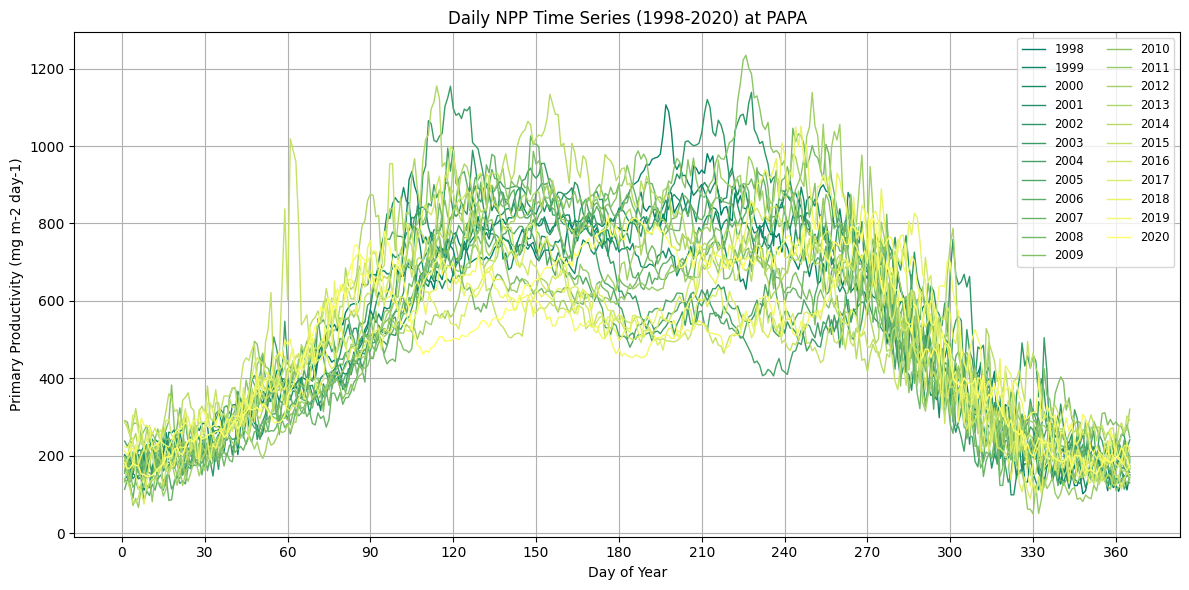

In [57]:
# Plot NPP Forcing
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Group by year
years = np.unique(pd.DatetimeIndex(npp_west_vgpm_cafe.time.values).year)
# Create a colormap with as many colors as there are years
cmap = plt.get_cmap('summer', len(years))
norm = mcolors.Normalize(vmin=years.min(), vmax=years.max())

# Plot one line per year with color from the colormap
for i, year in enumerate(years):
    yearly_data = npp_west_vgpm_cafe.sel(time=str(year))
    color = cmap(i)  # or cmap(norm(year)) if using Normalize
    ax.plot(yearly_data['day'], yearly_data.values, linewidth=1, label=str(year), color=color)


# Axis labels and title
ax.set_title('Daily NPP Time Series (1998-2020) at PAPA')
ax.set_xlabel('Day of Year')
plt.xticks(np.arange(0,370,30))
ax.set_ylabel('Primary Productivity (mg m-2 day-1)')

# Add legend
ax.legend(loc='upper right', fontsize='small', ncol=2)

# Style and layout
ax.grid(True)
plt.tight_layout()
plt.show()


In [59]:
npp_west_vgpm_cafe.to_netcdf('/data/rd_exchange/sroyer/SEAPOPYM/NPP/west_vgpm_cafe_1998_2020_d_papa.nc')

### b - with CbPM Behrenfeld

In [44]:
npp_behr=ds_behr_papa['CbPM']

In [45]:
npp_behr_daily = npp_behr.interp(time=target_times)

behr_filled = npp_behr_daily.interpolate_na(dim='time', method='linear')
behr_filled = behr_filled.ffill(dim='time')
behr_filled = behr_filled.interpolate_na(dim='time', method='linear', fill_value="extrapolate")

In [58]:
# Concaténation le long d'une nouvelle dimension (par exemple "source")
stacked = xr.concat([behr_filled, cafe_filled, npp_vgpm],coords='minimal', dim="source")

# Moyenne sur la dimension "source"
npp_behr_vgpm_cafe = stacked.mean(dim="source").rename("npp")


In [60]:
npp_behr_vgpm_cafe.to_netcdf('/data/rd_exchange/sroyer/SEAPOPYM/NPP/behr_vgpm_cafe_1998_2020_d_papa.nc')